In [10]:
%cd /content

/content


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/2023_AIfactory_위성segmentation_202307/정유탱크/oiltank_dataset.zip

In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

import ast
from tqdm import tqdm

In [52]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/2023_AIfactory_위성segmentation_202307/정유탱크/train_data.csv')

df

,Unnamed: 0,index,train_data_loc,train_label_xy,tilled_label_xy,tilled_idx,tilled_image_path
0,0,0,OBJ02634_PS3_K3_NIA0126.png,"[(336.6415449432134, 339.1612715196364), (349....",0,0,0
1,1,0,OBJ02634_PS3_K3_NIA0126.png,"[(322.5874084582725, 352.4346226443028), (337....",0,0,0
2,2,0,OBJ02634_PS3_K3_NIA0126.png,"[(312.82759145484135, 367.2695444895181), (329...",0,0,0
3,3,0,OBJ02634_PS3_K3_NIA0126.png,"[(287.8424599260575, 390.3027126176158), (301....",0,0,0
4,4,0,OBJ02634_PS3_K3_NIA0126.png,"[(305.41013053223367, 394.59703209912556), (32...",0,0,0
...,...,...,...,...,...,...,...
1005,1005,67,OBJ05733_PS3_K3A_NIA0363.png,"[(946.3780053972047, 128.88179847646327), (959...",0,0,0
1006,1006,68,OBJ05760_PS3_K3A_NIA0365.png,"[(578.1284550609116, 225.30518552949212), (593...",0,0,0
1007,1007,69,OBJ05781_PS3_K3A_NIA0368.png,"[(86.25686800677065, 264.84640029489117), (98....",0,0,0
1008,1008,69,OBJ05781_PS3_K3A_NIA0368.png,"[(109.66569892916438, 271.8905213728775), (121...",0,0,0


In [76]:
#index 0번의 tile_idx=5 에 oil_tank 있음.


tile_size = 256  # 1024의 약수로
limit_ratio = 0.3  # 쪼갠 뒤 0.3 이하로 남아있으면 bbox 없음.
img_path = 'oiltank_dataset/train_images/'


tilled_idxs = [] #얘네들에다가 저장할거임
tilled_label_xys = []
tilled_image_path = []
tilled_indexs = []

df_per_index = df.groupby('index') #이미지별로 묶음


prev_index = -1
for index, data in tqdm(df_per_index): #index별로 dataframe 만듦.

  img_name = data.iloc[0]['train_data_loc'] # ~~~.png

  img = Image.open(img_path + img_name)
  image_array = np.array(img) #1024 1024 3

  for cur in range(len(data)): #이미지별 이미지속 bonudary box개수만큼 반복
    bbox = ast.literal_eval(data.iloc[cur]['train_label_xy']) #문자 리스트를 숫자 리스트로

    width_bbox = abs(bbox[0][0] - bbox[1][0])
    height_bbox = abs(bbox[0][1] - bbox[3][1])
    prev_area = width_bbox * height_bbox #이후 해당 픽셀에 얼마만큼 비율로 들어있는가 계산 위함.

    tile_idx=0
    for height in range(0,1024,tile_size): ##### 중요 : 넓이를 이용하여 비율 및 어디에 속하는지 계산 ####
      for width in range(0,1024,tile_size):

          tile_img_path = f'{img_path}/{img_name[:-4]}_{tile_idx}.png'

          if(prev_index!=index): #처음 1번만 저장
            tilled_img = image_array[ height:height+tile_size , width:width+tile_size, : ] # [tile_size,tile_size,3] shape
            tilled_img = Image.fromarray(tilled_img)
            tilled_img.save(tile_img_path) # ~~~_tile_idx.png 형태 저장

          new_bbox = []
          for xy in bbox: #새로운 bbox 만들어서 넓이 비교
            new_x = xy[0]- height
            new_y = xy[1]- width


            if(new_x>=tile_size): #범위 초과한거 bbox안으로 집어넣어줌.
                new_x = tile_size-1
            if(new_y>=tile_size):
                new_y = tile_size-1

            if(new_x<0):
                new_x = 0
            if(new_y<0):
                new_y = 0

            new_bbox.append( ( new_x, new_y ) )

          width_bbox = abs(new_bbox[0][0] - new_bbox[1][0])
          height_bbox = abs(new_bbox[0][1] - new_bbox[3][1])
          after_area = width_bbox * height_bbox #이후 해당 픽셀에 얼마만큼 비율로 들어있는가 계산 위함.


          if(after_area/prev_area >= limit_ratio): #최소비율보다 높으면 추가
              tilled_idxs.append(tile_idx) #각 이미지의 몇 번 타일인지
              tilled_label_xys.append(new_bbox)
              tilled_image_path.append(tile_img_path)
              tilled_indexs.append(index) #몇 번 이미지인지

          tile_idx+=1
  prev_index = index

100%|██████████| 70/70 [10:30<00:00,  9.01s/it]


In [77]:
new_df = {}

new_df['tilled_label_xy'] = tilled_label_xys
new_df['tilled_idx'] = tilled_idxs
new_df['tilled_image_path'] = tilled_image_path
new_df['image_indexs'] = tilled_indexs

new_df = pd.DataFrame(new_df)

new_df

,tilled_label_xy,tilled_idx,tilled_image_path,image_indexs
0,"[(80.64154494321338, 83.16127151963639), (93.4...",5,oiltank_dataset/train_images//OBJ02634_PS3_K3_...,0
1,"[(66.58740845827248, 96.4346226443028), (81.32...",5,oiltank_dataset/train_images//OBJ02634_PS3_K3_...,0
2,"[(56.827591454841354, 111.26954448951813), (73...",5,oiltank_dataset/train_images//OBJ02634_PS3_K3_...,0
3,"[(31.842459926057472, 134.30271261761578), (45...",5,oiltank_dataset/train_images//OBJ02634_PS3_K3_...,0
4,"[(49.410130532233666, 138.59703209912556), (65...",5,oiltank_dataset/train_images//OBJ02634_PS3_K3_...,0
...,...,...,...,...
1095,"[(178.37800539720467, 128.88179847646327), (19...",12,oiltank_dataset/train_images//OBJ05733_PS3_K3A...,67
1096,"[(66.12845506091162, 225.30518552949212), (81....",8,oiltank_dataset/train_images//OBJ05760_PS3_K3A...,68
1097,"[(86.25686800677065, 8.846400294891168), (98.1...",1,oiltank_dataset/train_images//OBJ05781_PS3_K3A...,69
1098,"[(109.66569892916438, 15.890521372877515), (12...",1,oiltank_dataset/train_images//OBJ05781_PS3_K3A...,69


In [79]:
new_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/2023_AIfactory_위성segmentation_202307/정유탱크/tilled_train_data.csv')

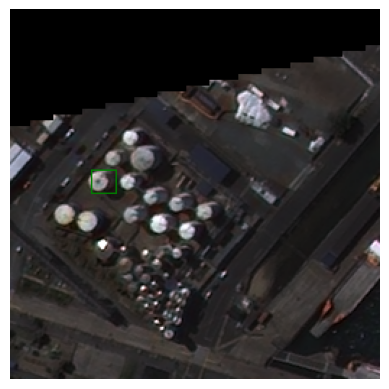

In [90]:
#테스트
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

idx = 2

img = Image.open( new_df['tilled_image_path'][idx] )
bbox = new_df['tilled_label_xy'][idx]

plt.axis('off')
draw = ImageDraw.Draw(img)

points = [ (point[0], point[1]) for point in bbox]

draw.polygon(points, outline='green', fill=None)

plt.imshow(img)